# Imports and Function Definitions

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
from polygon import RESTClient

import datetime as dt

In [9]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [250]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25), n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [365]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [457]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-01-01", to="2022-06-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-01-01", to="2022-06-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-01-01", to="2022-06-01", limit=50000)

In [458]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [459]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [461]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [462]:
fut = pd.read_csv('C:\\Users\\nfischer\\Downloads\\LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('C:\\Users\\nfischer\\Downloads\\GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('C:\\Users\\nfischer\\Downloads\\BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('C:\\Users\\nfischer\\Downloads\\USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [473]:
data_dict = {'fut':fut, 'gas':gas, 'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [475]:
idx = pd.to_datetime(data_dict['fut']['Local time'])
idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [476]:
for data in data_dict.keys():
    if not data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:
        data_dict[data] = data_dict[data].set_index('Local time')

## Merging

In [477]:
df = pd.DataFrame(index=data_dict['vxx'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

In [478]:
df

,Close_fut,Close_gas,Close_vxx,Close_spy,Close_btc,Close_bond
Local time,,,,,,
2022-01-03 09:00:00,101.968,4.5080,18.22,476.56,43675,158.177
2022-01-03 09:10:00,102.657,4.5300,18.15,476.83,43663,158.586
2022-01-03 09:15:00,101.602,4.5026,18.14,476.53,43965,158.301
2022-01-03 09:20:00,102.202,4.5136,18.19,476.82,43904,158.587
2022-01-03 09:25:00,102.572,4.5091,18.21,476.76,43860,158.678
...,...,...,...,...,...,...
2022-04-22 14:55:00,101.611,6.4821,25.16,NaN,39530,140.211
2022-04-22 15:00:00,101.618,6.4716,25.21,NaN,39452,140.179
2022-04-22 15:05:00,101.107,6.4549,25.00,NaN,39492,140.180


## Create log returns

Calculate log returns for each feature.

In [479]:
for feat in df.columns:
    df[feat] = np.log( df[feat] / df[feat].shift(1) )

Lots of nulls.  Fix later

In [481]:
df.loc[df['Close_spy'].isna()][:50]

,Close_fut,Close_gas,Close_vxx,Close_spy,Close_btc,Close_bond
Local time,,,,,,
2022-01-03 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07 23:40:00,0.000000,0.000000,0.000000,NaN,-0.000209,0.000000
2022-01-07 23:45:00,0.000000,0.000000,-0.000531,NaN,0.000262,0.000000
2022-01-08 00:30:00,0.001049,0.001739,0.000000,NaN,0.000043,0.000000
2022-01-08 00:40:00,0.002443,0.003291,0.001062,NaN,-0.002661,-0.000188
2022-01-10 10:05:00,0.000000,0.000000,-0.003170,NaN,0.000156,0.000000
2022-01-10 10:10:00,0.000000,0.000000,-0.002649,NaN,0.000622,0.000000
2022-01-10 11:45:00,0.000000,0.000000,-0.004188,NaN,-0.000780,0.000000
2022-01-10 12:00:00,0.000000,0.000000,0.000000,NaN,0.001611,0.000000


Fill nulls with spline interpolation.  

In [469]:
df = df.interpolate(method='spline', order=3)

In [470]:
df

,Close_fut,Close_gas,Close_vxx,Close_uso,Close_spy,Close_btc,Close_bond
Local time,,,,,,,
2022-01-03 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-03 09:10:00,0.006734,0.004868,-0.003849,NaN,0.000566,-0.000275,0.002582
2022-01-03 09:15:00,-0.010330,-0.006067,-0.000551,NaN,-0.000629,0.006893,-0.001799
2022-01-03 09:20:00,0.005888,0.002440,0.002753,NaN,0.000608,-0.001388,0.001805
2022-01-03 09:25:00,0.003614,-0.000997,0.001099,NaN,-0.000126,-0.001003,0.000574
...,...,...,...,...,...,...,...
2022-04-22 14:55:00,-0.000797,0.004205,-0.000397,0.000000,0.000277,0.001874,0.000442
2022-04-22 15:00:00,0.000069,-0.001621,0.001985,0.002086,0.000277,-0.001975,-0.000228
2022-04-22 15:05:00,-0.005041,-0.002584,-0.008365,-0.001564,0.000277,0.001013,0.000007


## Process each day separately

Doing this shows that some dates have missing data for the Polygon data.  This sucks

In [445]:
days = list(set([d.date() for d in df.index]))

In [482]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

Now we split the data into individual days.  We calculate the $n$ period rolling standard deviation as our outcome measure within each day.  Then, we can chain days together hopefully.  Otherwise we can train within each day.

In [447]:
n=10
day_dict = {}
for day in days:
    day_dict[day] = df.loc[df['date'] == day]
    day_dict[day] = df.loc[df['time'] > ]
    del day_dict[day]['date']
    
    day_dict[day][str(n)+'_oil_std'] = day_dict[day].rolling(n)['Close_fut'].std()
    day_dict[day] = day_dict[day][n:]

In [448]:
day_dict[dt.date(2021, 2, 23)][n:]

,Close_fut,Close_gas,Close_vxx,Close_uso,Close_spy,Close_btc,Close_bond,10_oil_std
Local time,,,,,,,,
2021-02-23 10:40:00,-0.000163,-0.001080,-0.002481,0.000004,0.000078,-0.005410,0.000425,0.003094
2021-02-23 10:45:00,0.000650,0.001741,-0.008734,0.002881,0.000468,-0.001711,-0.000413,0.003065
2021-02-23 10:50:00,0.002109,-0.001393,-0.005655,0.000000,0.000780,0.005902,-0.000400,0.002216
2021-02-23 10:55:00,-0.001784,-0.003246,0.001889,0.000959,-0.000910,-0.005966,0.000222,0.002000
2021-02-23 11:00:00,-0.001137,0.000070,0.006894,0.000003,-0.000469,0.003651,0.000394,0.001932
...,...,...,...,...,...,...,...,...
2021-02-23 23:35:00,0.001311,0.000532,-0.003286,0.000003,0.001136,0.003872,-0.000191,0.000822
2021-02-23 23:40:00,0.000491,-0.001490,0.001316,-0.000728,-0.000516,-0.001607,-0.000018,0.000833
2021-02-23 23:45:00,-0.000491,-0.000391,-0.002633,0.000003,0.000000,-0.002465,0.000400,0.000833


<AxesSubplot: xlabel='Local time'>

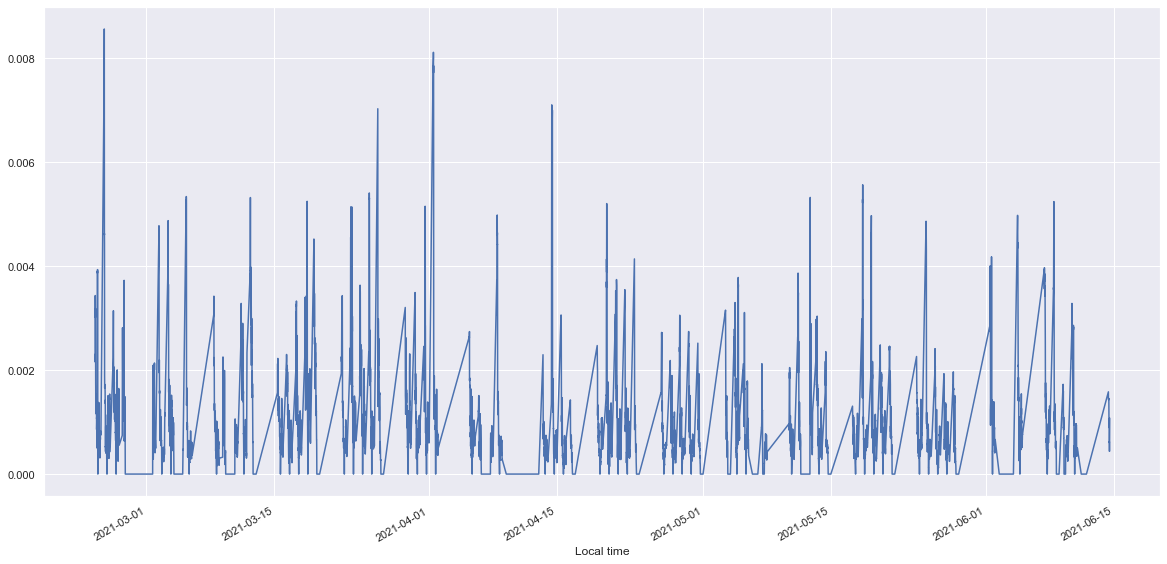

In [453]:
plt.subplots(figsize=(20,10))
pd.concat(day_dict.values())['10_oil_std'].plot()

In [456]:
test = pd.concat(day_dict.values())['10_oil_std']
test.loc[test==0]

Local time
2021-03-22 16:45:00    0.0
2021-03-22 16:50:00    0.0
2021-03-22 16:55:00    0.0
2021-05-06 09:35:00    0.0
2021-05-06 09:45:00    0.0
                      ... 
2021-03-09 23:30:00    0.0
2021-03-09 23:35:00    0.0
2021-03-09 23:40:00    0.0
2021-03-09 23:50:00    0.0
2021-03-09 23:55:00    0.0
Name: 10_oil_std, Length: 1523, dtype: float64

# Test Train Splits

## Making Vol (Outcome)

Use historical $n$-period standard deviation.  We will use $n=6.5_{\text{trading hours}}*12_{\text{multiples of 5 minutes per hour}}=78$

In [220]:
n=78

In [221]:
day['fut_'+str(n)+'_std'] = day.rolling(n)['Close_fut'].std()

In [249]:
day

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 08:00:00+05:00,0.007811,-0.000343,0.001665,0.000018,NaN
2021-09-08 08:05:00+05:00,0.002790,-0.001594,-0.002165,-0.000018,NaN
2021-09-08 08:10:00+05:00,-0.004361,-0.001719,0.001622,0.000402,NaN
2021-09-08 08:15:00+05:00,0.001057,0.000172,-0.000263,0.000164,NaN
2021-09-08 08:20:00+05:00,0.001961,0.004919,0.001466,-0.000359,NaN
...,...,...,...,...,...
2021-09-08 15:40:00+05:00,-0.000150,-0.000248,0.000437,-0.000196,0.001713
2021-09-08 15:45:00+05:00,-0.001048,-0.000495,-0.003366,-0.000190,0.001675
2021-09-08 15:50:00+05:00,0.000449,0.000248,-0.000943,0.000196,0.001670


In [233]:
X = day.drop('fut_78_std', axis=1)[77:]
Y = day['fut_78_std'][77:]

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Initial Model testing

In [251]:
res = {'RF':None, 'GB':None}
for model in res.keys():
    r = model_selection(model)
    res[model] = r

RF
RandomForestRegressor(max_depth=3, n_estimators=10)
MAE:  0.0001873201182509463 
MSE:  3.739762390653617e-08 
RMSE:  0.00019338465271715894
GB
GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10)
MAE:  0.00020812947123731586 
MSE:  4.332753712585249e-08 
RMSE:  0.00020815267744098918


In [244]:
day[77:]

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 14:25:00+05:00,0.000374,-0.000469,-0.000216,0.000397,0.002224
2021-09-08 14:30:00+05:00,-0.000075,-0.000592,-0.002829,-0.000385,0.002045
2021-09-08 14:35:00+05:00,0.000749,0.000049,-0.000043,0.000000,0.002023
2021-09-08 14:40:00+05:00,-0.001182,-0.003926,-0.000628,0.000000,0.001964
2021-09-08 14:45:00+05:00,0.000135,-0.000223,0.000433,-0.000214,0.001961
2021-09-08 14:50:00+05:00,0.000599,-0.000471,-0.007409,0.000006,0.001950
2021-09-08 14:55:00+05:00,-0.000898,0.000198,0.002772,-0.000568,0.001943
2021-09-08 15:00:00+05:00,0.000225,0.000273,0.003286,-0.000177,0.001827
2021-09-08 15:05:00+05:00,0.000509,-0.000050,0.002386,-0.000208,0.001791


In [252]:
res

{'RF': (RandomForestRegressor(max_depth=3, n_estimators=10),
  array([0.00191586, 0.00188938, 0.00184308, 0.00178188])),
 'GB': (GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10),
  array([0.00187836, 0.00187836, 0.00187836, 0.00187836]))}